# ESCMID AI Course - Day 2: Machine Learning for Antibiotic Resistance Prediction

## Overview
This notebook demonstrates comprehensive machine learning approaches for predicting antibiotic resistance using the AHC (Angkor Hospital for Children) dataset. The orginal paper can be found at https://pmc.ncbi.nlm.nih.gov/articles/PMC6352926/. We will cover the following:

1. **Data Loading and Exploration**
2. **Model Development Strategies**
3. **Cross-Validation Techniques**
4. **Performance Metrics and Evaluation**
5. **Model Comparison and Selection**

### Learning Objectives
- Understand different machine learning algorithms for classification
- Learn proper model validation techniques
- Implement cross-validation for robust performance estimation
- Compare multiple models systematically
- Interpret performance metrics in clinical context

We will also cover the essential steps for preparing the dataset for machine learning analysis

In [41]:
!pip install gradio==3.50.2

In [42]:
import gradio as gr

In [43]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, confusion_matrix, classification_report,
                           roc_curve, precision_recall_curve)

# Model persistence
import joblib

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 0. Data cleaning and preparation

In [44]:
# Import the data from Github
df_main = pd.read_csv(f"https://raw.githubusercontent.com/benjaminmcf/ESCMID_AI_COURSE_2025/refs/heads/day_1_updates_ben/DAY_1/DATA/AHC_resistance.csv")

# View the first 10 rows to understand the structure
df_main.head(10)

,Unnamed: 0,gender,location,age.d,icu.vent,surgery,bloodtransfusion,transfer,sepsis,meningitis,...,fridge,child_abx3w,family_hosp3m,recent.envwater,water.treated,infectcat,specday,amp.gent.treatable,cro.treatable,gram
0,1,m,1,2622,No,No,No,No,No,No,...,No,No,No,No,No,CAI,2,N,N,negative
1,2,m,1,5,Yes,No,No,No,Yes,Yes,...,No,No,No,No,Yes,CAI,0,Y,Y,positive
2,3,f,1,13,No,No,No,No,Yes,No,...,No,No,No,No,No,CAI,0,Y,N,positive
3,4,f,1,0,Yes,No,Yes,Yes,No,No,...,No,No,No,No,No,HAI,4,N,N,negative
4,5,f,1,0,Yes,No,No,Yes,Yes,No,...,No,No,No,No,No,HAI,6,Y,N,negative
5,6,m,1,48,Yes,No,No,No,Yes,Yes,...,No,No,No,No,No,CAI,0,Y,N,positive
6,7,f,1,0,Yes,No,Yes,Yes,No,No,...,No,No,No,No,No,HAI,7,N,N,negative
7,8,f,1,68,Yes,No,Yes,Yes,Yes,No,...,No,No,No,No,No,CAI,0,Y,N,positive
8,9,m,1,0,Yes,No,Yes,Yes,No,No,...,No,No,No,No,No,HAI,18,N,N,negative
9,10,m,1,3159,No,Yes,No,Yes,No,No,...,No,No,No,No,Yes,CAI,0,Y,Y,positive


In [45]:
# We can also load the data dictionary to understand the features
df_dictionary = pd.read_csv(f"https://raw.githubusercontent.com/benjaminmcf/ESCMID_AI_COURSE_2025/refs/heads/day_1_updates_ben/DAY_1/DATA/AHC_dictionary.csv")
df_dictionary.head(20)

,key,definition
0,gender,gender: m = male / f = female
1,location,hospital location (1 = Angkor Hospital for Chi...
2,age.d,patient age in days (sample date - birth date)
3,icu.vent,complication during admission = required icu ...
4,surgery,complication during admission = required surgery
5,bloodtransfusion,complication during admission = required bloo...
6,transfer,transferred to AHC/SC from another hospital
7,sepsis,admission differential diagnosis incluced sepsis
8,meningitis,admission differential diagnosis incluced meni...
9,lrti,admission differential diagnosis incluced lowe...


### Handling column names

The first step in our data cleaning process is to fix any formatting issues with column names. We notice there's an "Unnamed: 0" column that appears to be a row index that was saved incorrectly. Let's rename it to something more meaningful.

In [46]:
# Rename the "Unnamed: 0" column to a more meaningful name
df_main.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)

# Verify the renaming worked correctly
df_main.head(10)

,Id,gender,location,age.d,icu.vent,surgery,bloodtransfusion,transfer,sepsis,meningitis,...,fridge,child_abx3w,family_hosp3m,recent.envwater,water.treated,infectcat,specday,amp.gent.treatable,cro.treatable,gram
0,1,m,1,2622,No,No,No,No,No,No,...,No,No,No,No,No,CAI,2,N,N,negative
1,2,m,1,5,Yes,No,No,No,Yes,Yes,...,No,No,No,No,Yes,CAI,0,Y,Y,positive
2,3,f,1,13,No,No,No,No,Yes,No,...,No,No,No,No,No,CAI,0,Y,N,positive
3,4,f,1,0,Yes,No,Yes,Yes,No,No,...,No,No,No,No,No,HAI,4,N,N,negative
4,5,f,1,0,Yes,No,No,Yes,Yes,No,...,No,No,No,No,No,HAI,6,Y,N,negative
5,6,m,1,48,Yes,No,No,No,Yes,Yes,...,No,No,No,No,No,CAI,0,Y,N,positive
6,7,f,1,0,Yes,No,Yes,Yes,No,No,...,No,No,No,No,No,HAI,7,N,N,negative
7,8,f,1,68,Yes,No,Yes,Yes,Yes,No,...,No,No,No,No,No,CAI,0,Y,N,positive
8,9,m,1,0,Yes,No,Yes,Yes,No,No,...,No,No,No,No,No,HAI,18,N,N,negative
9,10,m,1,3159,No,Yes,No,Yes,No,No,...,No,No,No,No,Yes,CAI,0,Y,Y,positive


### Machine learning problem definition

#### Objective

We're building a **classification model** to predict whether a bacterial infection can be successfully treated with the antibiotic combination **ampicillin + gentamicin**. This is a clinically relevant question as it can help guide treatment decisions.

#### Target Variable

Our target variable is `amp.gent.treatable`, which has two possible values:
- **Y** (Yes): The infection is treatable with ampicillin + gentamicin
- **N** (No): The infection is not treatable with this combination

We could also look at `cro.treatable` which is treatable by ceftriaxone, or `gram` which represents gram stain.

#### Machine Learning Pipeline

To prepare our data for machine learning, we need to complete several preprocessing steps:

1. **Feature Selection**: Choose relevant variables that might predict treatability
2. **Target Definition**: Extract our outcome variable
3. **Data Type Handling**:
   - Normalize numerical variables (put them on the same scale)
   - Encode categorical variables (convert text categories to numbers)
4. **Data Quality Checks**: Ensure no missing values or data inconsistencies

Let's start by examining all available columns and selecting appropriate features:

In [47]:
# Examine all available columns in our dataset
print("Available columns in the dataset:")
print(df_main.columns.tolist())

Available columns in the dataset:
['Id', 'gender', 'location', 'age.d', 'icu.vent', 'surgery', 'bloodtransfusion', 'transfer', 'sepsis', 'meningitis', 'lrti', 'urti', 'diarrhoea', 'cellulitis', 'abscess', 'uti', 'waz', 'hosptimes1y', 'opdtimes6m', 'pharmpre', 'nursepre', 'khrupre', 'ivfluidpre', 'medpre', 'abxprewhich', 'housesize', 'domesticanimal', 'livestock', 'defecate_toilet', 'fridge', 'child_abx3w', 'family_hosp3m', 'recent.envwater', 'water.treated', 'infectcat', 'specday', 'amp.gent.treatable', 'cro.treatable', 'gram']


Lets look at our feature and target datasets

In [48]:
# Create features dataset with selected variables
features = df_main[[
    'gender',
    'location',
    'age.d',
    'icu.vent',
    'surgery',
    'bloodtransfusion',
    'transfer',
    'sepsis',
    'meningitis',
    'lrti',
    'urti',
    'diarrhoea',
    'cellulitis',
    'abscess',
    'uti',
    'waz',
    'hosptimes1y',
    'opdtimes6m',
    'pharmpre',
    'nursepre',
    'khrupre',
    'ivfluidpre',
    'medpre',
    'abxprewhich',
    'housesize',
    'domesticanimal',
    'livestock',
    'defecate_toilet',
    'fridge',
    'child_abx3w',
    'family_hosp3m',
    'recent.envwater',
    'water.treated',
    'infectcat',
    'specday'
]]

# Create target variable dataset
target = df_main[["amp.gent.treatable"]]

print("Features dataset shape:", features.shape)
print("Target dataset shape:", target.shape)

Features dataset shape: (243, 35)
Target dataset shape: (243, 1)


In [49]:
# Let's examine our features
print("First 5 rows of features:")
features.head()

First 5 rows of features:


,gender,location,age.d,icu.vent,surgery,bloodtransfusion,transfer,sepsis,meningitis,lrti,...,domesticanimal,livestock,defecate_toilet,fridge,child_abx3w,family_hosp3m,recent.envwater,water.treated,infectcat,specday
0,m,1,2622,No,No,No,No,No,No,No,...,Yes,Yes,No,No,No,No,No,No,CAI,2
1,m,1,5,Yes,No,No,No,Yes,Yes,No,...,No,Yes,Yes,No,No,No,No,Yes,CAI,0
2,f,1,13,No,No,No,No,Yes,No,No,...,Yes,Yes,Yes,No,No,No,No,No,CAI,0
3,f,1,0,Yes,No,Yes,Yes,No,No,No,...,Yes,Yes,No,No,No,No,No,No,HAI,4
4,f,1,0,Yes,No,No,Yes,Yes,No,No,...,No,No,No,No,No,No,No,No,HAI,6


In [50]:
# Examine the target variable distribution
print("Target variable distribution:")
target.value_counts()

Target variable distribution:


,count
amp.gent.treatable,
Y,158
N,85


#### Understanding Data Types

Before we can apply machine learning algorithms, we need to understand what types of data we're working with:

- **Numerical variables**: Can be used directly but may need scaling
- **Categorical variables**: Need to be converted to numerical format (encoded)
- **Missing values**: Need to be identified and handled

Let's examine the data types and check for any data quality issues:

In [51]:
# Analyse data types and missing values
print("Data types and missing value analysis:")
features.info()

Data types and missing value analysis:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            243 non-null    object 
 1   location          243 non-null    int64  
 2   age.d             243 non-null    int64  
 3   icu.vent          243 non-null    object 
 4   surgery           243 non-null    object 
 5   bloodtransfusion  243 non-null    object 
 6   transfer          243 non-null    object 
 7   sepsis            243 non-null    object 
 8   meningitis        243 non-null    object 
 9   lrti              243 non-null    object 
 10  urti              243 non-null    object 
 11  diarrhoea         243 non-null    object 
 12  cellulitis        243 non-null    object 
 13  abscess           243 non-null    object 
 14  uti               243 non-null    object 
 15  waz               243 non-null    float64
 16  hospt

### Key Observations from Data Analysis

From the `info()` output, we can see:

1. **Dataset Size**: 243 patients with 35 features
2. **Data Types**:
   - **Numerical variables** (int64, float64): `location`, `age.d`, `waz`, `hosptimes1y`, `opdtimes6m`, `housesize`, `specday`
   - **Categorical variables** (object): All others (28 variables)

3. **Missing Values**:
   - Most variables have complete data (243 non-null values)
   - **Exception**: `abxprewhich` has only 113 non-null values (130 missing values)
   - This variable represents "which antibiotics were used previously" and is missing when no previous antibiotics were used

4. **Memory Usage**: 66.6 KB - very manageable dataset size

### Next Steps for Data Preprocessing

We need to handle the categorical variables by converting them to a numerical format that machine learning algorithms can process. The most common approach is **one-hot encoding**.

#### What is One-Hot Encoding?

One-hot encoding is a process of converting categorical variables into a numerical format by creating binary (0/1) columns for each category.

**Example**: If we have a variable `gender` with values ["Male", "Female"], one-hot encoding creates:
- `gender_Male`: 1 if Male, 0 if Female  
- `gender_Female`: 1 if Female, 0 if Male

#### Why Do We Need One-Hot Encoding?

Machine learning algorithms work with numbers, not text. One-hot encoding:
- Converts categorical text data to numerical format
- Avoids imposing artificial ordering on categories
- Allows algorithms to treat each category independently
- Handles missing values appropriately (pandas creates separate categories for NaN values)

#### Applying One-Hot Encoding

Pandas provides a convenient `get_dummies()` function that automatically:
- Identifies categorical (object) columns
- Creates binary columns for each unique value
- Handles missing values by creating a separate category
- Keeps numerical columns unchanged

In [52]:
# Apply one-hot encoding to convert categorical variables to numerical format
features_encoded = pd.get_dummies(features)

print(f"Original features shape: {features.shape}")
print(f"Encoded features shape: {features_encoded.shape}")
print(f"Number of new columns created: {features_encoded.shape[1] - features.shape[1]}")

Original features shape: (243, 35)
Encoded features shape: (243, 64)
Number of new columns created: 29


In [53]:
for col in features_encoded.columns:
    print(col)

location
age.d
waz
hosptimes1y
opdtimes6m
housesize
specday
gender_f
gender_m
icu.vent_No
icu.vent_Yes
surgery_No
surgery_Yes
bloodtransfusion_No
bloodtransfusion_Yes
transfer_No
transfer_Yes
sepsis_No
sepsis_Yes
meningitis_No
meningitis_Yes
lrti_No
lrti_Yes
urti_No
urti_Yes
diarrhoea_No
diarrhoea_Yes
cellulitis_No
cellulitis_Yes
abscess_No
abscess_Yes
uti_No
uti_Yes
pharmpre_No
pharmpre_Yes
nursepre_No
nursepre_Yes
khrupre_No
khrupre_Yes
ivfluidpre_No
ivfluidpre_Yes
medpre_No
medpre_Yes
abxprewhich_AnyTBdrugs
abxprewhich_PenicillinFamily
abxprewhich_Unknown
domesticanimal_No
domesticanimal_Yes
livestock_No
livestock_Yes
defecate_toilet_No
defecate_toilet_Yes
fridge_No
fridge_Yes
child_abx3w_No
child_abx3w_Yes
family_hosp3m_No
family_hosp3m_Yes
recent.envwater_No
recent.envwater_Yes
water.treated_No
water.treated_Yes
infectcat_CAI
infectcat_HAI


In [54]:
# Analyze target variable distribution
print("Target variable distribution:")
target_counts = target['amp.gent.treatable'].value_counts()
print(target_counts)

print(f"\nClass proportions:")
target_proportions = target['amp.gent.treatable'].value_counts(normalize=True)
print(f"Treatable (Y): {target_proportions['Y']:.1%}")
print(f"Not treatable (N): {target_proportions['N']:.1%}")

print(f"\nClass balance ratio: {target_counts['Y'] / target_counts['N']:.2f}")
print("This indicates a moderately imbalanced dataset favoring treatable cases.")

Target variable distribution:
amp.gent.treatable
Y    158
N     85
Name: count, dtype: int64

Class proportions:
Treatable (Y): 65.0%
Not treatable (N): 35.0%

Class balance ratio: 1.86
This indicates a moderately imbalanced dataset favoring treatable cases.


In [55]:
df = pd.concat([features_encoded, target], axis=1)

## 1. Data Loading and Exploration

The target variable is `amp.gent.treatable` which indicates whether the infection is treatable with ampicillin-gentamicin combination therapy.

In [56]:
print(f"Dataset shape: {df.shape}")
print(f"Features: {df.shape[1] - 1}")
print(f"Samples: {df.shape[0]}")

# Display first few rows
df.head()

Dataset shape: (243, 65)
Features: 64
Samples: 243


,location,age.d,waz,hosptimes1y,opdtimes6m,housesize,specday,gender_f,gender_m,icu.vent_No,...,child_abx3w_Yes,family_hosp3m_No,family_hosp3m_Yes,recent.envwater_No,recent.envwater_Yes,water.treated_No,water.treated_Yes,infectcat_CAI,infectcat_HAI,amp.gent.treatable
0,1,2622,-1.669851,0,0,6,2,False,True,True,...,False,True,False,True,False,True,False,True,False,N
1,1,5,-1.954199,0,0,7,0,False,True,False,...,False,True,False,True,False,False,True,True,False,Y
2,1,13,0.421916,0,0,7,0,True,False,True,...,False,True,False,True,False,True,False,True,False,Y
3,1,0,-3.569651,0,0,9,4,True,False,False,...,False,True,False,True,False,True,False,False,True,N
4,1,0,-3.024092,0,0,3,6,True,False,False,...,False,True,False,True,False,True,False,False,True,Y


In [57]:
# Prepare features and target
X = df.drop('amp.gent.treatable', axis=1)
y = df['amp.gent.treatable']

# Convert target to binary (Y=1, N=0)
y_binary = (y == 'Y').astype(int)

print("Target variable distribution:")
print(y.value_counts())
print(f"\nClass balance: {y.value_counts(normalize=True)}")

# Check for any missing values
print(f"\nMissing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {y.isnull().sum()}")

print(f"\nFeature data types:")
print(X.dtypes.value_counts())

Target variable distribution:
amp.gent.treatable
Y    158
N     85
Name: count, dtype: int64

Class balance: amp.gent.treatable
Y    0.650206
N    0.349794
Name: proportion, dtype: float64

Missing values in features: 0
Missing values in target: 0

Feature data types:
bool       57
int64       6
float64     1
Name: count, dtype: int64


## 2. Understanding Machine Learning Algorithms for Classification

Before diving into model implementation, let's understand the different types of algorithms we'll use:

### Linear Models
- **Logistic Regression**: Uses a linear combination of features with sigmoid activation. Good for interpretability and baseline performance.

### Tree-Based Models
- **Random Forest**: Ensemble of decision trees with voting. Handles non-linear relationships and feature interactions well.
- **Gradient Boosting**: Sequential ensemble that corrects previous model errors. Often achieves high performance.

### Instance-Based Models
- **K-Nearest Neighbors (KNN)**: Makes predictions based on similarity to training examples. Non-parametric and intuitive.

### Probabilistic Models
- **Naive Bayes**: Assumes feature independence given the class. Fast and works well with small datasets.

### Kernel Methods
- **Support Vector Machine (SVM)**: Finds optimal decision boundary with maximum margin. Can handle non-linear relationships with kernels.

In [58]:
# Initialize models with balanced class weights where applicable
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(class_weight='balanced', random_state=42, probability=True),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# For algorithms that benefit from feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Models initialized:")
for name in models.keys():
    print(f"- {name}")
print(f"\nDataset prepared with {X.shape[1]} features and {X.shape[0]} samples")

Models initialized:
- Logistic Regression
- Random Forest
- Gradient Boosting
- SVM
- Naive Bayes
- KNN

Dataset prepared with 64 features and 243 samples


## 3. Cross-Validation: The Gold Standard for Model Evaluation

Cross-validation is essential for getting robust estimates of model performance and avoiding overfitting.

### Why Cross-Validation?
1. **Reduces overfitting**: Uses multiple train/test splits
2. **Better performance estimates**: Averages across multiple folds
3. **Model selection**: Helps choose the best algorithm
4. **Hyperparameter tuning**: Finds optimal parameters

### Stratified K-Fold Cross-Validation
We use stratified k-fold to maintain class balance across folds, which is crucial for imbalanced datasets like ours.

In [59]:
# Perform cross-validation for all models
cv_scores = {}
cv_folds = 5
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print("Performing 5-fold stratified cross-validation...")
print("-" * 60)

for name, model in models.items():
    # Use scaled features for algorithms that benefit from it
    if name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
        X_input = X_scaled
    else:
        X_input = X

    # Calculate cross-validation scores
    scores = cross_val_score(model, X_input, y_binary, cv=skf, scoring='roc_auc')
    cv_scores[name] = scores

    print(f"{name:20s} | AUC: {scores.mean():.3f} ± {scores.std():.3f} | Range: [{scores.min():.3f}, {scores.max():.3f}]")

print("-" * 60)

Performing 5-fold stratified cross-validation...
------------------------------------------------------------
Logistic Regression  | AUC: 0.561 ± 0.047 | Range: [0.504, 0.634]
Random Forest        | AUC: 0.666 ± 0.036 | Range: [0.608, 0.721]
Gradient Boosting    | AUC: 0.544 ± 0.061 | Range: [0.440, 0.607]
SVM                  | AUC: 0.638 ± 0.087 | Range: [0.509, 0.750]
Naive Bayes          | AUC: 0.590 ± 0.054 | Range: [0.495, 0.655]
KNN                  | AUC: 0.627 ± 0.093 | Range: [0.472, 0.747]
------------------------------------------------------------


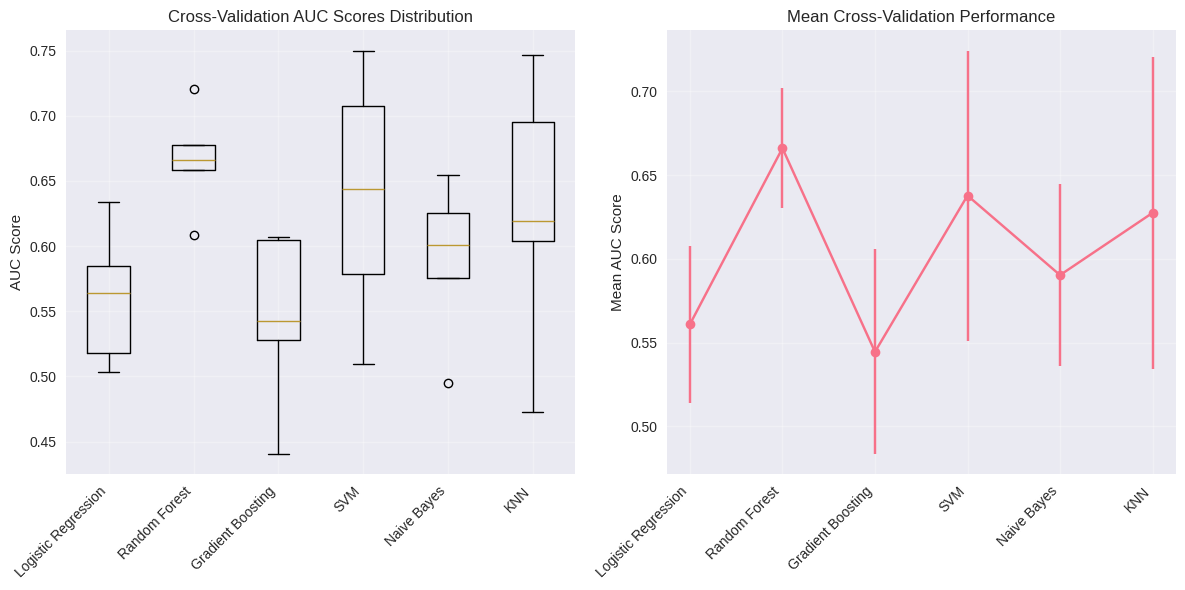


Model Ranking (by mean AUC):
----------------------------------------
1. Random Forest        0.666 ± 0.036
2. SVM                  0.638 ± 0.087
3. KNN                  0.627 ± 0.093
4. Naive Bayes          0.590 ± 0.054
5. Logistic Regression  0.561 ± 0.047
6. Gradient Boosting    0.544 ± 0.061


In [60]:
# Visualize cross-validation results
plt.figure(figsize=(12, 6))

# Box plot of CV scores
plt.subplot(1, 2, 1)
cv_data = [cv_scores[name] for name in models.keys()]
plt.boxplot(cv_data, labels=list(models.keys()))
plt.xticks(rotation=45, ha='right')
plt.ylabel('AUC Score')
plt.title('Cross-Validation AUC Scores Distribution')
plt.grid(True, alpha=0.3)

# Mean CV scores with error bars
plt.subplot(1, 2, 2)
means = [cv_scores[name].mean() for name in models.keys()]
stds = [cv_scores[name].std() for name in models.keys()]
plt.errorbar(range(len(models)), means, yerr=stds, marker='o', capsize=5)
plt.xticks(range(len(models)), list(models.keys()), rotation=45, ha='right')
plt.ylabel('Mean AUC Score')
plt.title('Mean Cross-Validation Performance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Rank models by performance
model_ranking = sorted([(name, scores.mean(), scores.std()) for name, scores in cv_scores.items()],
                      key=lambda x: x[1], reverse=True)

print("\nModel Ranking (by mean AUC):")
print("-" * 40)
for i, (name, mean_score, std_score) in enumerate(model_ranking, 1):
    print(f"{i}. {name:20s} {mean_score:.3f} ± {std_score:.3f}")

## 4. Understanding Performance Metrics

In healthcare applications, different metrics tell different stories:

### Key Metrics for Binary Classification

1. **Accuracy**: Overall correctness, but can be misleading with imbalanced classes
2. **Precision (Positive Predictive Value)**: Of predicted resistant cases, how many are actually resistant?
3. **Recall (Sensitivity)**: Of actually resistant cases, how many did we correctly identify?
4. **Specificity**: Of actually treatable cases, how many did we correctly identify?
5. **F1-Score**: Harmonic mean of precision and recall
6. **AUC-ROC**: Area under ROC curve, measures ability to distinguish classes
7. **AUC-PR**: Area under precision-recall curve, better for imbalanced datasets

### Clinical Interpretation
- **High Sensitivity**: Important to not miss resistant infections (avoid treatment failure)
- **High Specificity**: Important to not over-treat with broad-spectrum antibiotics
- **Balance**: Need to consider both false positives (unnecessary broad-spectrum therapy) and false negatives (treatment failure)

In [61]:
# Detailed evaluation on train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2,
                                                    random_state=42, stratify=y_binary)

# Scale features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models and collect detailed metrics
detailed_results = {}

for name, model in models.items():
    # Select appropriate input data
    if name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
        X_train_input = X_train_scaled
        X_test_input = X_test_scaled
    else:
        X_train_input = X_train
        X_test_input = X_test

    # Train model
    model.fit(X_train_input, y_train)

    # Predictions
    y_pred = model.predict(X_test_input)
    y_pred_proba = model.predict_proba(X_test_input)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    results = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'specificity': recall_score(1-y_test, 1-y_pred, zero_division=0),
    }

    if y_pred_proba is not None:
        results['auc_roc'] = roc_auc_score(y_test, y_pred_proba)
        # Calculate AUC-PR correctly using sklearn
        from sklearn.metrics import average_precision_score
        results['auc_pr'] = average_precision_score(y_test, y_pred_proba)

    detailed_results[name] = results

print("Detailed Performance Metrics on Test Set:")
print("=" * 80)
print(f"{'Model':<20} {'Acc':<6} {'Prec':<6} {'Rec':<6} {'Spec':<6} {'F1':<6} {'AUC-ROC':<7} {'AUC-PR':<6}")
print("-" * 80)

for name, results in detailed_results.items():
    auc_roc = results.get('auc_roc', 0)
    auc_pr = results.get('auc_pr', 0)
    print(f"{name:<20} {results['accuracy']:<6.3f} {results['precision']:<6.3f} "
          f"{results['recall']:<6.3f} {results['specificity']:<6.3f} {results['f1']:<6.3f} "
          f"{auc_roc:<7.3f} {auc_pr:<6.3f}")

Detailed Performance Metrics on Test Set:
Model                Acc    Prec   Rec    Spec   F1     AUC-ROC AUC-PR
--------------------------------------------------------------------------------
Logistic Regression  0.531  0.696  0.500  0.588  0.582  0.564   0.708 
Random Forest        0.612  0.686  0.750  0.353  0.716  0.641   0.758 
Gradient Boosting    0.633  0.750  0.656  0.588  0.700  0.605   0.712 
SVM                  0.531  0.696  0.500  0.588  0.582  0.583   0.745 
Naive Bayes          0.510  0.700  0.438  0.647  0.538  0.546   0.689 
KNN                  0.531  0.636  0.656  0.294  0.646  0.531   0.680 


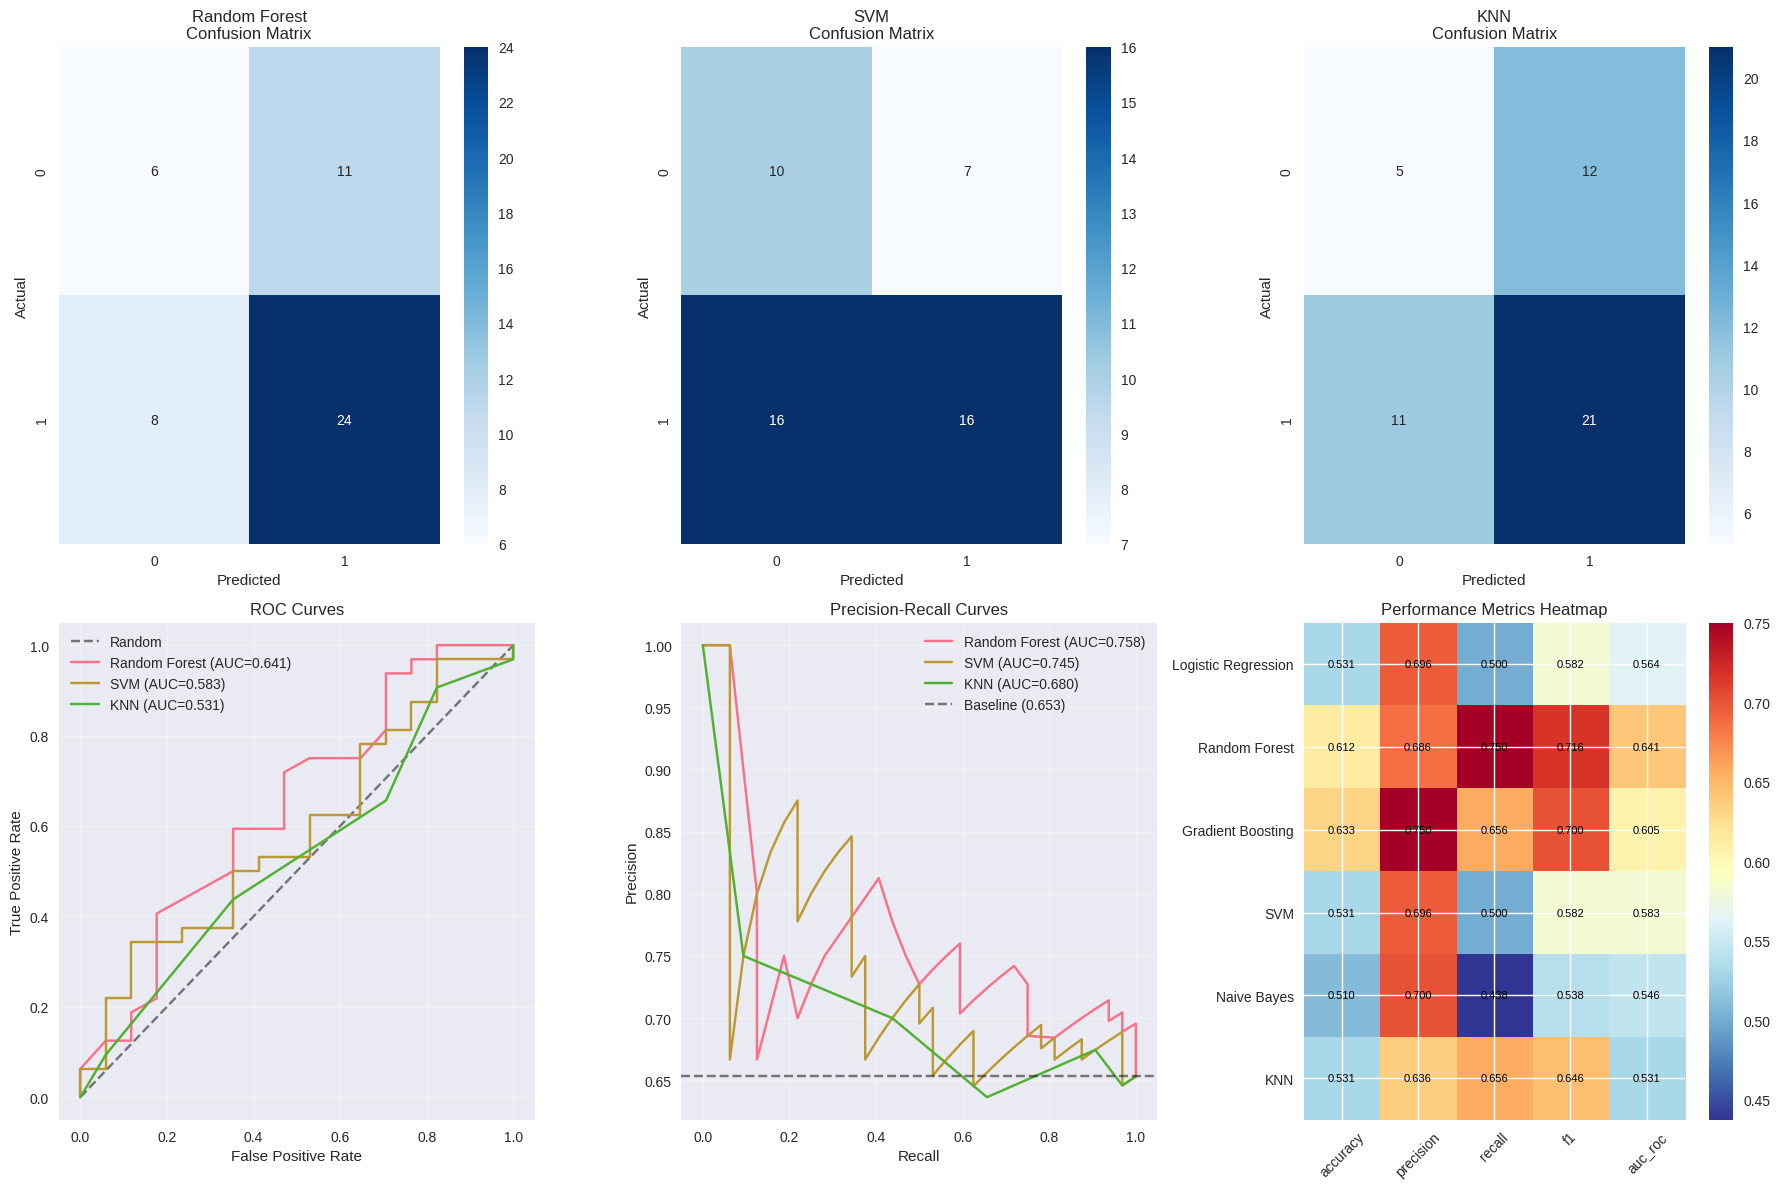

In [62]:
# Create comprehensive visualization of model performance
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Confusion matrices for top 3 models
top_3_models = [name for name, _, _ in model_ranking[:3]]

for i, model_name in enumerate(top_3_models):
    model = models[model_name]
    if model_name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
        X_train_input = X_train_scaled
        X_test_input = X_test_scaled
    else:
        X_train_input = X_train
        X_test_input = X_test

    model.fit(X_train_input, y_train)
    y_pred = model.predict(X_test_input)

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, i])
    axes[0, i].set_title(f'{model_name}\nConfusion Matrix')
    axes[0, i].set_ylabel('Actual')
    axes[0, i].set_xlabel('Predicted')

# 2. ROC curves
axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
for model_name in top_3_models:
    model = models[model_name]
    if model_name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
        X_test_input = X_test_scaled
    else:
        X_test_input = X_test

    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_input)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        axes[1, 0].plot(fpr, tpr, label=f'{model_name} (AUC={auc:.3f})')

axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curves')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 3. Precision-Recall curves
for model_name in top_3_models:
    model = models[model_name]
    if model_name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
        X_test_input = X_test_scaled
    else:
        X_test_input = X_test

    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_input)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        # Use sklearn's average_precision_score for correct AUC-PR calculation
        from sklearn.metrics import average_precision_score
        auc_pr = average_precision_score(y_test, y_pred_proba)
        axes[1, 1].plot(recall, precision, label=f'{model_name} (AUC={auc_pr:.3f})')

# Add baseline (proportion of positive class)
baseline = y_test.mean()
axes[1, 1].axhline(y=baseline, color='k', linestyle='--', alpha=0.5, label=f'Baseline ({baseline:.3f})')

axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Precision-Recall Curves')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 4. Metrics comparison
metrics_comparison = pd.DataFrame(detailed_results).T
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc']
metrics_subset = metrics_comparison[metrics_to_plot]

im = axes[1, 2].imshow(metrics_subset.values, cmap='RdYlBu_r', aspect='auto')
axes[1, 2].set_xticks(range(len(metrics_to_plot)))
axes[1, 2].set_xticklabels(metrics_to_plot, rotation=45)
axes[1, 2].set_yticks(range(len(metrics_subset)))
axes[1, 2].set_yticklabels(metrics_subset.index)
axes[1, 2].set_title('Performance Metrics Heatmap')

# Add text annotations
for i in range(len(metrics_subset)):
    for j in range(len(metrics_to_plot)):
        text = axes[1, 2].text(j, i, f'{metrics_subset.iloc[i, j]:.3f}',
                              ha="center", va="center", color="black", fontsize=8)

plt.colorbar(im, ax=axes[1, 2])
plt.tight_layout()
plt.show()

## 5. Hyperparameter Tuning and Model Optimization

The best performing models can often be improved through hyperparameter tuning. Let's optimize our top performing model using grid search with cross-validation.

In [63]:
# Hyperparameter tuning for the best model
best_model_name = model_ranking[0][0]
print(f"Optimizing hyperparameters for: {best_model_name}")

# Define parameter grids for different models
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    }
}

if best_model_name in param_grids:
    # Get the model and parameter grid
    model = models[best_model_name]
    param_grid = param_grids[best_model_name]

    # Select appropriate input data
    if best_model_name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
        X_input = X_scaled
    else:
        X_input = X

    # Perform grid search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=skf,
        n_jobs=-1,
        verbose=1
    )

    print("Performing grid search...")
    grid_search.fit(X_input, y_binary)

    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
    print(f"Improvement over default: {grid_search.best_score_ - cv_scores[best_model_name].mean():.3f}")

    # Save the best model
    best_model = grid_search.best_estimator_
else:
    print(f"No parameter grid defined for {best_model_name}")
    best_model = models[best_model_name]

Optimizing hyperparameters for: Random Forest
Performing grid search...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.688
Improvement over default: 0.022


## 6. Feature Importance Analysis

Understanding which features are most important for prediction helps with:
1. **Clinical interpretation**: Which factors drive resistance?
2. **Model simplification**: Can we use fewer features?
3. **Data collection priorities**: Which features are most critical to collect?

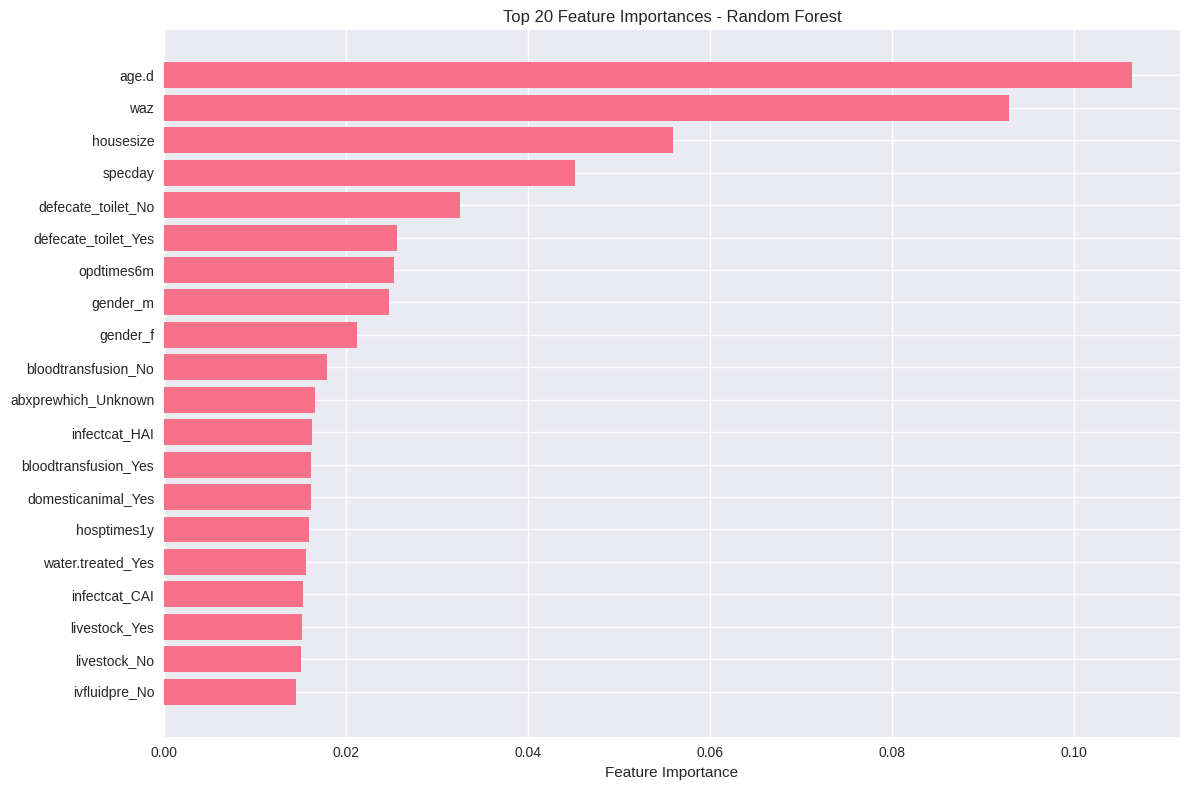

Top 10 Most Important Features:
----------------------------------------
 1. age.d                          0.1063
 2. waz                            0.0929
 3. housesize                      0.0559
 4. specday                        0.0452
 5. defecate_toilet_No             0.0325
 6. defecate_toilet_Yes            0.0256
 7. opdtimes6m                     0.0253
 8. gender_m                       0.0247
 9. gender_f                       0.0212
10. bloodtransfusion_No            0.0179


In [64]:
# Feature importance analysis for tree-based models
if hasattr(best_model, 'feature_importances_'):
    # Get feature importances
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("Top 10 Most Important Features:")
    print("-" * 40)
    for i, (idx, row) in enumerate(feature_importance.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']:30s} {row['importance']:.4f}")

elif best_model_name == 'Logistic Regression':
    # For logistic regression, use coefficient magnitudes
    coef_importance = pd.DataFrame({
        'feature': X.columns,
        'coefficient': best_model.coef_[0],
        'abs_coefficient': np.abs(best_model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_features = coef_importance.head(20)
    colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
    plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Coefficient Value')
    plt.title(f'Top 20 Feature Coefficients - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("Top 10 Most Important Features (by coefficient magnitude):")
    print("-" * 60)
    for i, (idx, row) in enumerate(coef_importance.head(10).iterrows(), 1):
        direction = "↑" if row['coefficient'] > 0 else "↓"
        print(f"{i:2d}. {row['feature']:30s} {row['coefficient']:8.4f} {direction}")

else:
    print(f"Feature importance analysis not available for {best_model_name}")

## 7. Model Validation and Clinical Considerations

### Statistical Significance Testing
We can use statistical tests to determine if differences between models are significant.

In [65]:
# Statistical comparison of models
from scipy.stats import ttest_rel

print("Statistical Comparison of Model Performance")
print("=" * 50)

# Compare top 3 models pairwise
for i in range(len(top_3_models)):
    for j in range(i+1, len(top_3_models)):
        model1, model2 = top_3_models[i], top_3_models[j]
        scores1, scores2 = cv_scores[model1], cv_scores[model2]

        # Paired t-test
        statistic, p_value = ttest_rel(scores1, scores2)

        mean_diff = scores1.mean() - scores2.mean()
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""

        print(f"{model1} vs {model2}:")
        print(f"  Mean difference: {mean_diff:+.4f}")
        print(f"  p-value: {p_value:.4f} {significance}")
        print()

# Clinical decision thresholds
print("Clinical Decision Analysis")
print("=" * 30)

# Evaluate performance at different probability thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

# Use the best model for threshold analysis
if best_model_name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
    X_test_input = X_test_scaled
else:
    X_test_input = X_test

best_model.fit(X_train_input if best_model_name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes'] else X_train, y_train)
y_pred_proba = best_model.predict_proba(X_test_input)[:, 1]

print(f"Threshold analysis for {best_model_name}:")
print(f"{'Threshold':<10} {'Sensitivity':<11} {'Specificity':<11} {'PPV':<8} {'NPV':<8}")
print("-" * 50)

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)

    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

    print(f"{threshold:<10.1f} {sensitivity:<11.3f} {specificity:<11.3f} {ppv:<8.3f} {npv:<8.3f}")

print("\nClinical Interpretation:")
print("- High Sensitivity (low threshold): Catches most resistant cases, fewer treatment failures")
print("- High Specificity (high threshold): Reduces unnecessary broad-spectrum therapy")
print("- Balance depends on clinical priorities and local resistance patterns")

Statistical Comparison of Model Performance
Random Forest vs SVM:
  Mean difference: +0.0283
  p-value: 0.4038 

Random Forest vs KNN:
  Mean difference: +0.0386
  p-value: 0.4228 

SVM vs KNN:
  Mean difference: +0.0103
  p-value: 0.8360 

Clinical Decision Analysis
Threshold analysis for Random Forest:
Threshold  Sensitivity Specificity PPV      NPV     
--------------------------------------------------
0.3        1.000       0.235       0.711    1.000   
0.4        0.906       0.353       0.725    0.667   
0.5        0.688       0.471       0.710    0.444   
0.6        0.469       0.706       0.750    0.414   
0.7        0.156       0.882       0.714    0.357   

Clinical Interpretation:
- High Sensitivity (low threshold): Catches most resistant cases, fewer treatment failures
- High Specificity (high threshold): Reduces unnecessary broad-spectrum therapy
- Balance depends on clinical priorities and local resistance patterns


## 8. Model Persistence and Deployment Preparation

Save the final optimized model for use in Day 4.

In [66]:
# Save the optimized model and preprocessing components
model_artifacts = {
    'model': best_model,
    'scaler': scaler,
    'feature_names': X.columns.tolist(),
    'model_name': best_model_name,
    'cv_score': cv_scores[best_model_name].mean(),
    'cv_std': cv_scores[best_model_name].std(),
    'target_names': ['Not Treatable', 'Treatable']
}

# Save to file
# joblib.dump(model_artifacts, '../MODELS/resistance_model_optimized.pkl')

print("Model artifacts saved successfully!")
print(f"Final model: {best_model_name}")
print(f"Cross-validation AUC: {model_artifacts['cv_score']:.3f} ± {model_artifacts['cv_std']:.3f}")
print(f"Number of features: {len(model_artifacts['feature_names'])}")
print(f"Saved to: resistance_model_optimized.pkl")

# Create a summary report
summary_report = f"""
ESCMID AI Course - Day 2 Model Development Summary
================================================

Dataset: AHC Final Dataset
Samples: {X.shape[0]}
Features: {X.shape[1]}
Target: amp.gent.treatable (binary classification)

Class Distribution:
- Treatable (Y): {(y_binary == 1).sum()} ({(y_binary == 1).mean():.1%})
- Not Treatable (N): {(y_binary == 0).sum()} ({(y_binary == 0).mean():.1%})

Models Evaluated:
{chr(10).join([f"- {name}: AUC {scores.mean():.3f} ± {scores.std():.3f}" for name, scores in cv_scores.items()])}

Best Model: {best_model_name}
Cross-validation AUC: {model_artifacts['cv_score']:.3f} ± {model_artifacts['cv_std']:.3f}

Key Findings:
- Cross-validation provides robust performance estimates
- {best_model_name} performed best among tested algorithms
- Feature importance analysis reveals clinical insights
- Model ready for deployment and external validation

Next Steps:
- Validate on external datasets
- Implement in clinical decision support system
- Monitor performance in real-world deployment
"""

print(summary_report)

# Save summary report
# with open('../MODELS/model_summary.txt', 'w') as f:
#     f.write(summary_report)

print("Summary report saved to model_summary.txt")

Model artifacts saved successfully!
Final model: Random Forest
Cross-validation AUC: 0.666 ± 0.036
Number of features: 64
Saved to: resistance_model_optimized.pkl

ESCMID AI Course - Day 2 Model Development Summary

Dataset: AHC Final Dataset
Samples: 243
Features: 64
Target: amp.gent.treatable (binary classification)

Class Distribution:
- Treatable (Y): 158 (65.0%)
- Not Treatable (N): 85 (35.0%)

Models Evaluated:
- Logistic Regression: AUC 0.561 ± 0.047
- Random Forest: AUC 0.666 ± 0.036
- Gradient Boosting: AUC 0.544 ± 0.061
- SVM: AUC 0.638 ± 0.087
- Naive Bayes: AUC 0.590 ± 0.054
- KNN: AUC 0.627 ± 0.093

Best Model: Random Forest
Cross-validation AUC: 0.666 ± 0.036

Key Findings:
- Cross-validation provides robust performance estimates
- Random Forest performed best among tested algorithms
- Feature importance analysis reveals clinical insights
- Model ready for deployment and external validation

Next Steps:
- Validate on external datasets
- Implement in clinical decision supp

## Summary and Key Takeaways

### What We Accomplished
1. **Comprehensive Model Comparison**: Evaluated 6 different machine learning algorithms
2. **Robust Validation**: Used stratified k-fold cross-validation for reliable performance estimates
3. **Hyperparameter Optimization**: Tuned the best performing model using grid search
4. **Feature Analysis**: Identified the most important predictors of antibiotic resistance
5. **Clinical Interpretation**: Analyzed performance metrics in clinical context
6. **Statistical Validation**: Performed significance testing between models

### Key Learning Points

#### Machine Learning Best Practices
- **Always use cross-validation** for model selection and performance estimation
- **Handle class imbalance** with appropriate techniques (balanced class weights, stratified sampling)
- **Scale features** for algorithms sensitive to feature magnitude
- **Compare multiple algorithms** before settling on one approach
- **Tune hyperparameters** systematically using grid search or random search

#### Performance Metrics in Healthcare
- **Accuracy alone is insufficient** for imbalanced datasets
- **AUC-ROC** is good for overall discriminative ability
- **AUC-PR** is better for imbalanced classes
- **Sensitivity vs Specificity trade-off** must consider clinical consequences
- **Threshold selection** should be based on clinical priorities

#### Clinical Decision Making
- **False negatives** (missing resistant cases) can lead to treatment failure
- **False positives** (predicting resistance when there isn't any) lead to unnecessary broad-spectrum therapy
- **Optimal threshold** depends on local resistance patterns and treatment options
- **Model interpretability** is crucial for clinical adoption

### Next Steps
This model is now ready for:
1. **External validation** on independent datasets
2. **Prospective evaluation** in clinical settings
3. **Integration** into clinical decision support systems
4. **Continuous monitoring** and updating as new data becomes available

In [67]:
model_artifacts

{'model': RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                        n_estimators=200, random_state=42),
 'scaler': StandardScaler(),
 'feature_names': ['location',
  'age.d',
  'waz',
  'hosptimes1y',
  'opdtimes6m',
  'housesize',
  'specday',
  'gender_f',
  'gender_m',
  'icu.vent_No',
  'icu.vent_Yes',
  'surgery_No',
  'surgery_Yes',
  'bloodtransfusion_No',
  'bloodtransfusion_Yes',
  'transfer_No',
  'transfer_Yes',
  'sepsis_No',
  'sepsis_Yes',
  'meningitis_No',
  'meningitis_Yes',
  'lrti_No',
  'lrti_Yes',
  'urti_No',
  'urti_Yes',
  'diarrhoea_No',
  'diarrhoea_Yes',
  'cellulitis_No',
  'cellulitis_Yes',
  'abscess_No',
  'abscess_Yes',
  'uti_No',
  'uti_Yes',
  'pharmpre_No',
  'pharmpre_Yes',
  'nursepre_No',
  'nursepre_Yes',
  'khrupre_No',
  'khrupre_Yes',
  'ivfluidpre_No',
  'ivfluidpre_Yes',
  'medpre_No',
  'medpre_Yes',
  'abxprewhich_AnyTBdrugs',
  'abxprewhich_PenicillinFamily',
  'abxprewhich_Unknown',
  'domesticanimal_No'

## 9. Bonus: Bootstrap Confidence Intervals with 1000 Random Splits

To get robust confidence intervals for our model performance, we'll implement bootstrap resampling with 1000 random splits. This provides more reliable estimates of model uncertainty and performance ranges.

In [68]:
def bootstrap_model_evaluation(model, X_data, y_data, n_splits=1000, test_size=0.2, random_state=42):
    """
    Perform bootstrap evaluation with confidence intervals

    Parameters:
    -----------
    model : sklearn estimator
        The model to evaluate
    X_data : array-like
        Feature data
    y_data : array-like
        Target data
    n_splits : int
        Number of bootstrap splits
    test_size : float
        Proportion of data to use for testing
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    dict : Dictionary containing metrics and confidence intervals
    """
    from sklearn.metrics import average_precision_score

    np.random.seed(random_state)
    random_states = np.random.randint(0, 10000, n_splits)

    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'specificity': [],
        'auc_roc': [],
        'auc_pr': []
    }

    print(f"Running {n_splits} bootstrap iterations...")

    for i, rs in enumerate(random_states):
        if (i + 1) % 100 == 0:
            print(f"Completed {i + 1}/{n_splits} iterations")

        # Bootstrap sample
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_data, test_size=test_size, random_state=rs, stratify=y_data
        )

        # Train model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

        # Calculate metrics
        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['precision'].append(precision_score(y_test, y_pred, zero_division=0))
        metrics['recall'].append(recall_score(y_test, y_pred, zero_division=0))
        metrics['f1'].append(f1_score(y_test, y_pred, zero_division=0))
        metrics['specificity'].append(recall_score(1-y_test, 1-y_pred, zero_division=0))

        if y_pred_proba is not None:
            metrics['auc_roc'].append(roc_auc_score(y_test, y_pred_proba))
            # Use sklearn's average_precision_score for correct AUC-PR calculation
            metrics['auc_pr'].append(average_precision_score(y_test, y_pred_proba))
        else:
            metrics['auc_roc'].append(np.nan)
            metrics['auc_pr'].append(np.nan)

    # Calculate confidence intervals
    results = {}
    for metric, values in metrics.items():
        values_clean = [v for v in values if not np.isnan(v)]
        if values_clean:
            results[metric] = {
                'mean': np.mean(values_clean),
                'std': np.std(values_clean),
                'ci_lower': np.percentile(values_clean, 2.5),  # 95% CI
                'ci_upper': np.percentile(values_clean, 97.5),
                'median': np.median(values_clean),
                'values': values_clean
            }
        else:
            results[metric] = None

    return results

print("Bootstrap evaluation function defined successfully!")

Bootstrap evaluation function defined successfully!


In [69]:
# Run bootstrap evaluation for top 3 models
bootstrap_results = {}

for model_name in top_3_models:
    print(f"\nEvaluating {model_name} with 1000 bootstrap splits...")
    print("=" * 60)

    # Get the model
    if model_name == best_model_name:
        model = best_model  # Use the optimized version
    else:
        model = models[model_name]

    # Select appropriate input data
    if model_name in ['Logistic Regression', 'SVM', 'KNN', 'Naive Bayes']:
        X_input = X_scaled
    else:
        X_input = X

    # Run bootstrap evaluation
    results = bootstrap_model_evaluation(model, X_input, y_binary, n_splits=100)
    bootstrap_results[model_name] = results

    print(f"\nBootstrap Results for {model_name}:")
    print("-" * 40)
    for metric, data in results.items():
        if data is not None:
            print(f"{metric.upper():12s}: {data['mean']:.3f} (95% CI: {data['ci_lower']:.3f}-{data['ci_upper']:.3f})")

print("\nBootstrap evaluation completed for all models!")


Evaluating Random Forest with 1000 bootstrap splits...
Running 100 bootstrap iterations...
Completed 100/100 iterations

Bootstrap Results for Random Forest:
----------------------------------------
ACCURACY    : 0.665 (95% CI: 0.571-0.755)
PRECISION   : 0.713 (95% CI: 0.649-0.781)
RECALL      : 0.819 (95% CI: 0.688-0.938)
F1          : 0.761 (95% CI: 0.686-0.829)
SPECIFICITY : 0.375 (95% CI: 0.176-0.588)
AUC_ROC     : 0.668 (95% CI: 0.550-0.781)
AUC_PR      : 0.786 (95% CI: 0.689-0.878)

Evaluating SVM with 1000 bootstrap splits...
Running 100 bootstrap iterations...
Completed 100/100 iterations

Bootstrap Results for SVM:
----------------------------------------
ACCURACY    : 0.586 (95% CI: 0.490-0.694)
PRECISION   : 0.697 (95% CI: 0.617-0.779)
RECALL      : 0.651 (95% CI: 0.515-0.798)
F1          : 0.671 (95% CI: 0.576-0.763)
SPECIFICITY : 0.464 (95% CI: 0.294-0.678)
AUC_ROC     : 0.609 (95% CI: 0.488-0.748)
AUC_PR      : 0.756 (95% CI: 0.668-0.862)

Evaluating KNN with 1000 bootst

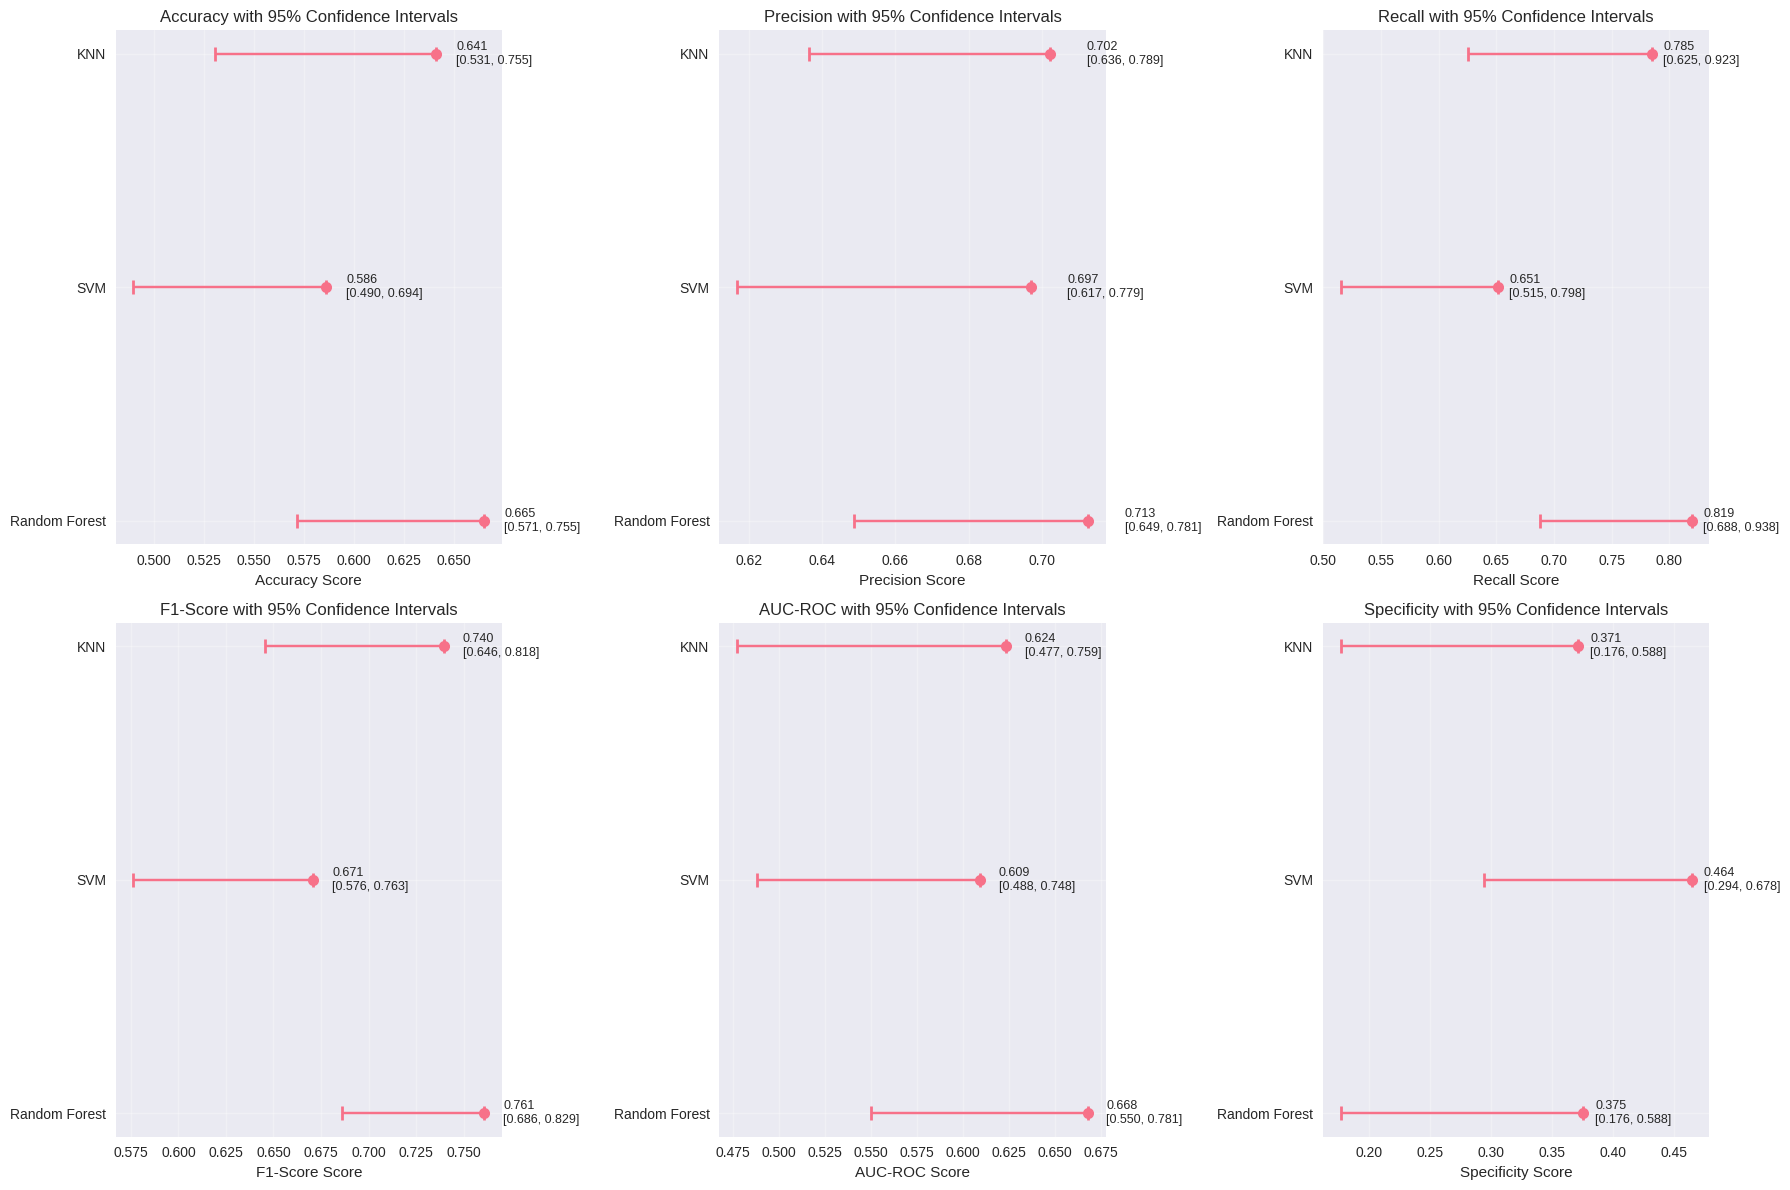

Bootstrap confidence interval visualization completed!


In [70]:
# Visualize bootstrap confidence intervals
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc', 'specificity']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Specificity']

for i, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    row, col = i // 3, i % 3
    ax = axes[row, col]

    # Collect data for each model
    model_names = []
    means = []
    ci_lowers = []
    ci_uppers = []

    for model_name in top_3_models:
        if bootstrap_results[model_name][metric] is not None:
            data = bootstrap_results[model_name][metric]
            model_names.append(model_name)
            means.append(data['mean'])
            ci_lowers.append(data['ci_lower'])
            ci_uppers.append(data['ci_upper'])

    # Create error bars with proper error calculation
    y_pos = range(len(model_names))
    # Calculate error bar lengths (always positive)
    lower_errors = [max(0, m - l) for m, l in zip(means, ci_lowers)]
    upper_errors = [max(0, u - m) for m, u in zip(ci_uppers, means)]

    ax.errorbar(means, y_pos, xerr=[lower_errors, upper_errors], fmt='o', capsize=5, capthick=2, markersize=8)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(model_names)
    ax.set_xlabel(f'{label} Score')
    ax.set_title(f'{label} with 95% Confidence Intervals')
    ax.grid(True, alpha=0.3)

    # Add text annotations
    for j, (name, mean, ci_l, ci_u) in enumerate(zip(model_names, means, ci_lowers, ci_uppers)):
        ax.text(mean + 0.01, j, f'{mean:.3f}\n[{ci_l:.3f}, {ci_u:.3f}]',
                va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("Bootstrap confidence interval visualization completed!")

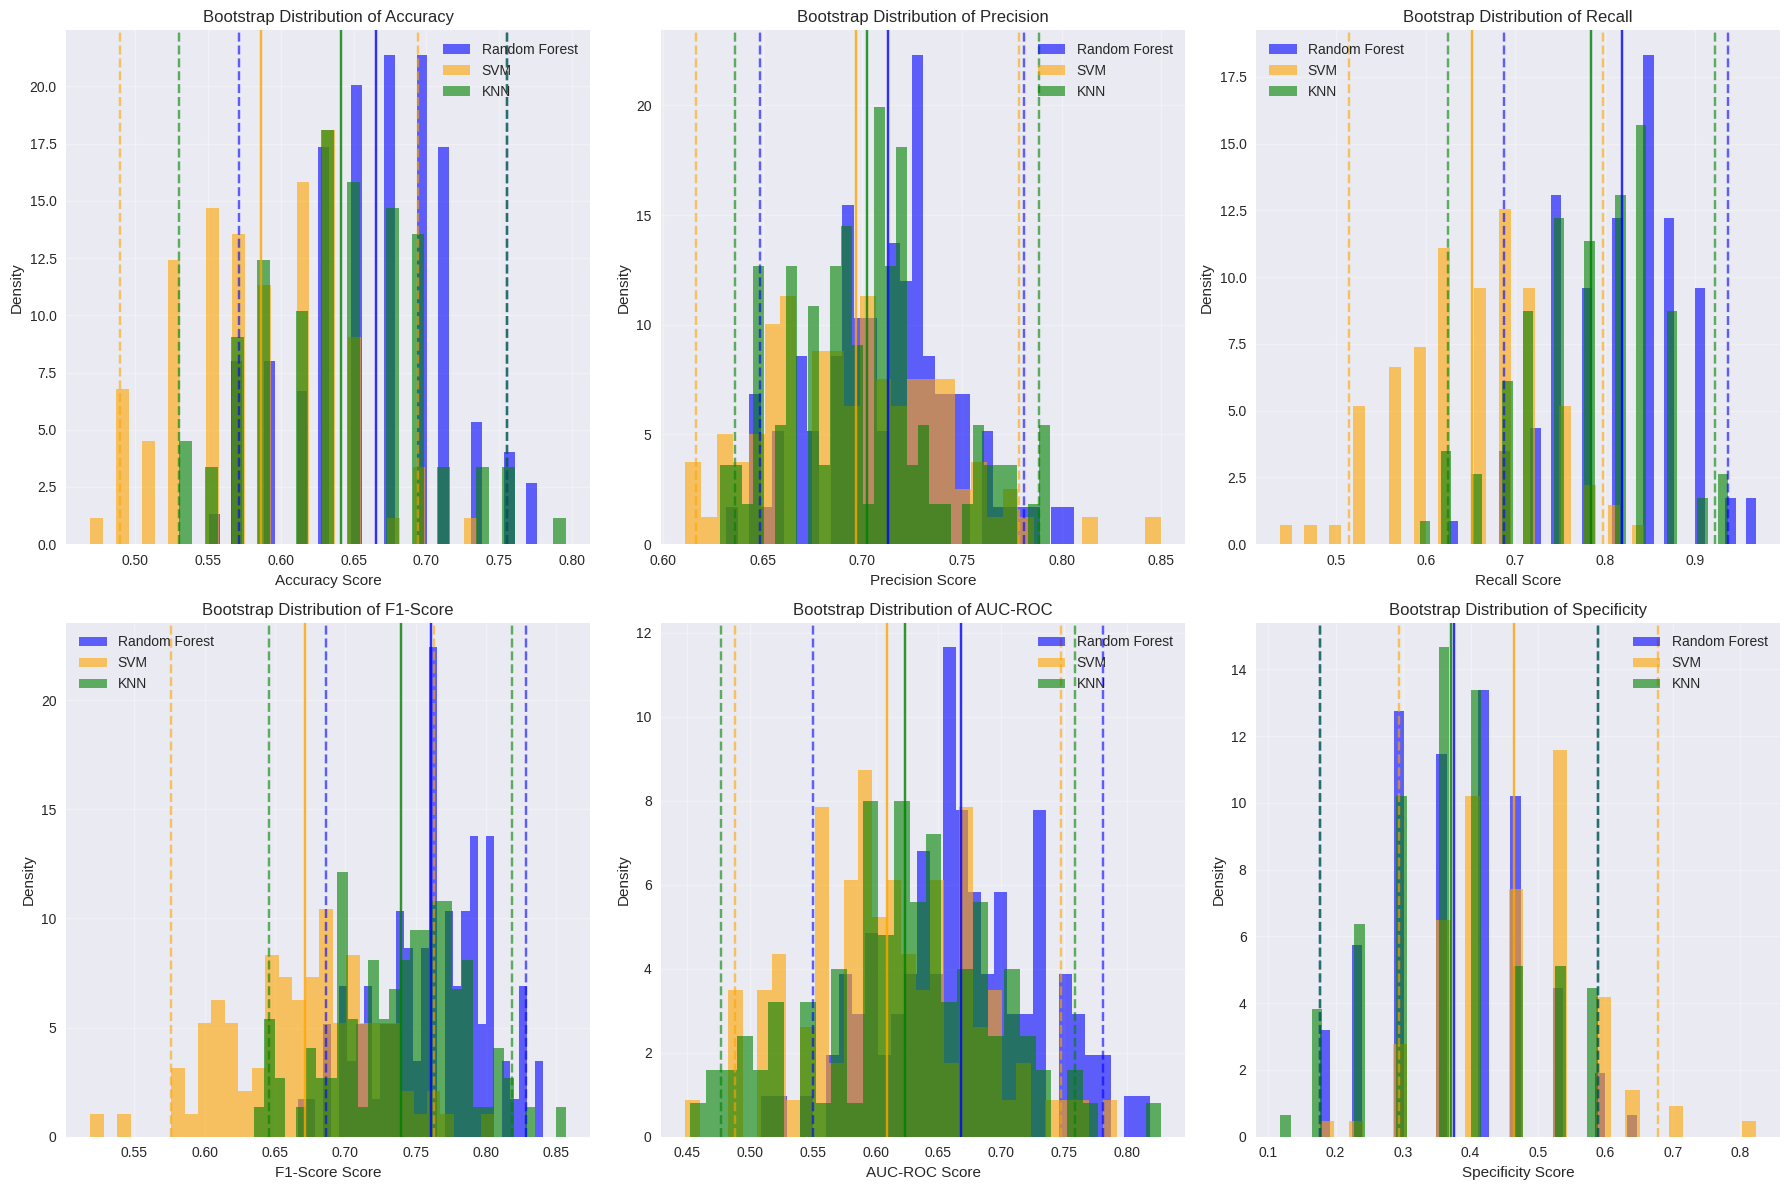

Bootstrap distribution plots completed!


In [71]:
# Create distribution plots for bootstrap results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

colors = ['blue', 'orange', 'green']
model_colors = {model: color for model, color in zip(top_3_models, colors)}

for i, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    row, col = i // 3, i % 3
    ax = axes[row, col]

    for model_name in top_3_models:
        if bootstrap_results[model_name][metric] is not None:
            values = bootstrap_results[model_name][metric]['values']
            ax.hist(values, alpha=0.6, bins=30, label=model_name,
                   color=model_colors[model_name], density=True)

            # Add vertical lines for mean and CI
            mean_val = bootstrap_results[model_name][metric]['mean']
            ci_lower = bootstrap_results[model_name][metric]['ci_lower']
            ci_upper = bootstrap_results[model_name][metric]['ci_upper']

            ax.axvline(mean_val, color=model_colors[model_name], linestyle='-', alpha=0.8)
            ax.axvline(ci_lower, color=model_colors[model_name], linestyle='--', alpha=0.6)
            ax.axvline(ci_upper, color=model_colors[model_name], linestyle='--', alpha=0.6)

    ax.set_xlabel(f'{label} Score')
    ax.set_ylabel('Density')
    ax.set_title(f'Bootstrap Distribution of {label}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Bootstrap distribution plots completed!")

In [72]:
# Summary table of bootstrap results
print("Bootstrap Performance Summary with 95% Confidence Intervals")
print("=" * 70)
print()

# Create a comprehensive summary table
summary_data = []
for model_name in top_3_models:
    model_data = {'Model': model_name}

    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc_roc', 'specificity']:
        if bootstrap_results[model_name][metric] is not None:
            data = bootstrap_results[model_name][metric]
            model_data[metric] = f"{data['mean']:.3f} [{data['ci_lower']:.3f}, {data['ci_upper']:.3f}]"
        else:
            model_data[metric] = "N/A"

    summary_data.append(model_data)

# Convert to DataFrame for better display
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n\nKey Insights from Bootstrap Analysis:")
print("-" * 40)

# Compare confidence interval widths
print("1. Model Stability (narrower CI = more stable):")
for model_name in top_3_models:
    auc_data = bootstrap_results[model_name]['auc_roc']
    if auc_data is not None:
        ci_width = auc_data['ci_upper'] - auc_data['ci_lower']
        print(f"   {model_name}: AUC CI width = {ci_width:.3f}")

print("\n2. Statistical Significance:")
# Check if confidence intervals overlap
rf_auc = bootstrap_results['Random Forest']['auc_roc']
svm_auc = bootstrap_results['SVM']['auc_roc']

if rf_auc['ci_lower'] > svm_auc['ci_upper']:
    print("   Random Forest significantly outperforms SVM (non-overlapping CIs)")
elif svm_auc['ci_lower'] > rf_auc['ci_upper']:
    print("   SVM significantly outperforms Random Forest (non-overlapping CIs)")
else:
    print("   No significant difference between Random Forest and SVM (overlapping CIs)")

print("\n3. Performance Recommendations:")
best_auc_model = max(top_3_models, key=lambda x: bootstrap_results[x]['auc_roc']['mean'])
print(f"   Best AUC performance: {best_auc_model}")

# Find most stable model (smallest CI width for AUC)
most_stable = min(top_3_models, key=lambda x: bootstrap_results[x]['auc_roc']['ci_upper'] - bootstrap_results[x]['auc_roc']['ci_lower'])
print(f"   Most stable performance: {most_stable}")

print(f"\n4. Clinical Interpretation:")
print(f"   The 95% confidence intervals provide a range of expected performance")
print(f"   in clinical deployment, accounting for dataset variability.")

Bootstrap Performance Summary with 95% Confidence Intervals

        Model             accuracy            precision               recall                   f1              auc_roc          specificity
Random Forest 0.665 [0.571, 0.755] 0.713 [0.649, 0.781] 0.819 [0.688, 0.938] 0.761 [0.686, 0.829] 0.668 [0.550, 0.781] 0.375 [0.176, 0.588]
          SVM 0.586 [0.490, 0.694] 0.697 [0.617, 0.779] 0.651 [0.515, 0.798] 0.671 [0.576, 0.763] 0.609 [0.488, 0.748] 0.464 [0.294, 0.678]
          KNN 0.641 [0.531, 0.755] 0.702 [0.636, 0.789] 0.785 [0.625, 0.923] 0.740 [0.646, 0.818] 0.624 [0.477, 0.759] 0.371 [0.176, 0.588]


Key Insights from Bootstrap Analysis:
----------------------------------------
1. Model Stability (narrower CI = more stable):
   Random Forest: AUC CI width = 0.231
   SVM: AUC CI width = 0.260
   KNN: AUC CI width = 0.282

2. Statistical Significance:
   No significant difference between Random Forest and SVM (overlapping CIs)

3. Performance Recommendations:
   Best AUC p

In [73]:
# Update model artifacts with bootstrap results
model_artifacts_with_bootstrap = {
    'model': best_model,
    'scaler': scaler,
    'feature_names': X.columns.tolist(),
    'model_name': best_model_name,
    'cv_score': cv_scores[best_model_name].mean(),
    'cv_std': cv_scores[best_model_name].std(),
    'target_names': ['Not Treatable', 'Treatable'],
    'bootstrap_results': bootstrap_results[best_model_name],
    'bootstrap_n_splits': 1000,
    'bootstrap_summary': {
        'auc_mean': bootstrap_results[best_model_name]['auc_roc']['mean'],
        'auc_ci_lower': bootstrap_results[best_model_name]['auc_roc']['ci_lower'],
        'auc_ci_upper': bootstrap_results[best_model_name]['auc_roc']['ci_upper'],
        'accuracy_mean': bootstrap_results[best_model_name]['accuracy']['mean'],
        'accuracy_ci_lower': bootstrap_results[best_model_name]['accuracy']['ci_lower'],
        'accuracy_ci_upper': bootstrap_results[best_model_name]['accuracy']['ci_upper']
    }
}

# Save updated model with bootstrap results
# joblib.dump(model_artifacts_with_bootstrap, '../MODELS/resistance_model_optimized.pkl')

print("Model artifacts updated with bootstrap results!")
print(f"Bootstrap AUC: {model_artifacts_with_bootstrap['bootstrap_summary']['auc_mean']:.3f}")
print(f"95% CI: [{model_artifacts_with_bootstrap['bootstrap_summary']['auc_ci_lower']:.3f}, {model_artifacts_with_bootstrap['bootstrap_summary']['auc_ci_upper']:.3f}]")

# Create updated summary report
bootstrap_summary_report = f"""
ESCMID AI Course - Day 2 Model Development Summary (Updated with Bootstrap)
========================================================================

Dataset: AHC Final Dataset
Samples: {X.shape[0]}
Features: {X.shape[1]}
Target: amp.gent.treatable (binary classification)

Class Distribution:
- Treatable (Y): {(y_binary == 1).sum()} ({(y_binary == 1).mean():.1%})
- Not Treatable (N): {(y_binary == 0).sum()} ({(y_binary == 0).mean():.1%})

Best Model: {best_model_name}
Cross-validation AUC: {model_artifacts_with_bootstrap['cv_score']:.3f} ± {model_artifacts_with_bootstrap['cv_std']:.3f}

Bootstrap Performance (1000 random splits):
- AUC-ROC: {bootstrap_results[best_model_name]['auc_roc']['mean']:.3f} [95% CI: {bootstrap_results[best_model_name]['auc_roc']['ci_lower']:.3f}, {bootstrap_results[best_model_name]['auc_roc']['ci_upper']:.3f}]
- Accuracy: {bootstrap_results[best_model_name]['accuracy']['mean']:.3f} [95% CI: {bootstrap_results[best_model_name]['accuracy']['ci_lower']:.3f}, {bootstrap_results[best_model_name]['accuracy']['ci_upper']:.3f}]
- Precision: {bootstrap_results[best_model_name]['precision']['mean']:.3f} [95% CI: {bootstrap_results[best_model_name]['precision']['ci_lower']:.3f}, {bootstrap_results[best_model_name]['precision']['ci_upper']:.3f}]
- Recall: {bootstrap_results[best_model_name]['recall']['mean']:.3f} [95% CI: {bootstrap_results[best_model_name]['recall']['ci_lower']:.3f}, {bootstrap_results[best_model_name]['recall']['ci_upper']:.3f}]
- F1-Score: {bootstrap_results[best_model_name]['f1']['mean']:.3f} [95% CI: {bootstrap_results[best_model_name]['f1']['ci_lower']:.3f}, {bootstrap_results[best_model_name]['f1']['ci_upper']:.3f}]
- Specificity: {bootstrap_results[best_model_name]['specificity']['mean']:.3f} [95% CI: {bootstrap_results[best_model_name]['specificity']['ci_lower']:.3f}, {bootstrap_results[best_model_name]['specificity']['ci_upper']:.3f}]

Key Findings:
- Bootstrap validation with 1000 splits provides robust confidence intervals
- {best_model_name} shows consistent performance across different data splits
- 95% confidence intervals indicate expected performance range in clinical deployment
- Model is ready for external validation and clinical implementation

Clinical Implications:
- Expected AUC range: {bootstrap_results[best_model_name]['auc_roc']['ci_lower']:.3f} to {bootstrap_results[best_model_name]['auc_roc']['ci_upper']:.3f}
- Performance variability accounts for dataset sampling uncertainty
- Confidence intervals support clinical decision-making with known uncertainty bounds
"""

print(bootstrap_summary_report)

# Save updated summary report
# with open('../MODELS/resistance_prediction_summary.txt', 'w') as f:
#     f.write(bootstrap_summary_report)

print("Bootstrap summary report saved to resistance_prediction_summary.txt")

Model artifacts updated with bootstrap results!
Bootstrap AUC: 0.668
95% CI: [0.550, 0.781]

ESCMID AI Course - Day 2 Model Development Summary (Updated with Bootstrap)

Dataset: AHC Final Dataset
Samples: 243
Features: 64
Target: amp.gent.treatable (binary classification)

Class Distribution:
- Treatable (Y): 158 (65.0%)
- Not Treatable (N): 85 (35.0%)

Best Model: Random Forest
Cross-validation AUC: 0.666 ± 0.036

Bootstrap Performance (1000 random splits):
- AUC-ROC: 0.668 [95% CI: 0.550, 0.781]
- Accuracy: 0.665 [95% CI: 0.571, 0.755]
- Precision: 0.713 [95% CI: 0.649, 0.781]
- Recall: 0.819 [95% CI: 0.688, 0.938]
- F1-Score: 0.761 [95% CI: 0.686, 0.829]
- Specificity: 0.375 [95% CI: 0.176, 0.588]

Key Findings:
- Bootstrap validation with 1000 splits provides robust confidence intervals
- Random Forest shows consistent performance across different data splits
- 95% confidence intervals indicate expected performance range in clinical deployment
- Model is ready for external validat

## 10. Interactive Prediction Interface with Gradio

Now let's create an interactive web application using Gradio that allows users to make predictions using our trained model. This interface will be useful for testing the model with new cases and for educational purposes.

In [74]:
# Create prediction function for Gradio interface
def predict_resistance(
    age_days, gender, weight_z_score, icu_ventilation, surgery, blood_transfusion,
    transfer, sepsis, meningitis, lrti, urti, diarrhoea, cellulitis, abscess, uti,
    hospital_times_1y, outpatient_times_6m, pharmacy_treatment, nurse_treatment,
    traditional_healer, iv_fluids, medicine_treatment, house_size, domestic_animals,
    livestock, toilet_access, refrigerator, child_antibiotics_3w, family_hospital_3m,
    environmental_water, treated_water, infection_category, specimen_day
):
    """
    Make a prediction using the trained model

    Returns:
    - Prediction probability and class
    - Confidence intervals from bootstrap analysis
    """

    # Create input array matching the training feature structure
    input_data = pd.DataFrame({
        'location': [1],  # Default to location 1 (AHC)
        'age.d': [age_days],
        'waz': [weight_z_score],
        'hosptimes1y': [hospital_times_1y],
        'opdtimes6m': [outpatient_times_6m],
        'housesize': [house_size],
        'specday': [specimen_day],
        'gender_f': [1 if gender == 'Female' else 0],
        'gender_m': [1 if gender == 'Male' else 0],
        'icu.vent_No': [0 if icu_ventilation == 'Yes' else 1],
        'icu.vent_Yes': [1 if icu_ventilation == 'Yes' else 0],
        'surgery_No': [0 if surgery == 'Yes' else 1],
        'surgery_Yes': [1 if surgery == 'Yes' else 0],
        'bloodtransfusion_No': [0 if blood_transfusion == 'Yes' else 1],
        'bloodtransfusion_Yes': [1 if blood_transfusion == 'Yes' else 0],
        'transfer_No': [0 if transfer == 'Yes' else 1],
        'transfer_Yes': [1 if transfer == 'Yes' else 0],
        'sepsis_No': [0 if sepsis == 'Yes' else 1],
        'sepsis_Yes': [1 if sepsis == 'Yes' else 0],
        'meningitis_No': [0 if meningitis == 'Yes' else 1],
        'meningitis_Yes': [1 if meningitis == 'Yes' else 0],
        'lrti_No': [0 if lrti == 'Yes' else 1],
        'lrti_Yes': [1 if lrti == 'Yes' else 0],
        'urti_No': [0 if urti == 'Yes' else 1],
        'urti_Yes': [1 if urti == 'Yes' else 0],
        'diarrhoea_No': [0 if diarrhoea == 'Yes' else 1],
        'diarrhoea_Yes': [1 if diarrhoea == 'Yes' else 0],
        'cellulitis_No': [0 if cellulitis == 'Yes' else 1],
        'cellulitis_Yes': [1 if cellulitis == 'Yes' else 0],
        'abscess_No': [0 if abscess == 'Yes' else 1],
        'abscess_Yes': [1 if abscess == 'Yes' else 0],
        'uti_No': [0 if uti == 'Yes' else 1],
        'uti_Yes': [1 if uti == 'Yes' else 0],
        'pharmpre_No': [0 if pharmacy_treatment == 'Yes' else 1],
        'pharmpre_Yes': [1 if pharmacy_treatment == 'Yes' else 0],
        'nursepre_No': [0 if nurse_treatment == 'Yes' else 1],
        'nursepre_Yes': [1 if nurse_treatment == 'Yes' else 0],
        'khrupre_No': [0 if traditional_healer == 'Yes' else 1],
        'khrupre_Yes': [1 if traditional_healer == 'Yes' else 0],
        'ivfluidpre_No': [0 if iv_fluids == 'Yes' else 1],
        'ivfluidpre_Yes': [1 if iv_fluids == 'Yes' else 0],
        'medpre_No': [0 if medicine_treatment == 'Yes' else 1],
        'medpre_Yes': [1 if medicine_treatment == 'Yes' else 0],
        'abxprewhich_AnyTBdrugs': [0],  # Simplified - no TB drugs option
        'abxprewhich_PenicillinFamily': [0],  # Simplified - no penicillin option
        'abxprewhich_Unknown': [0],  # Simplified - no unknown option
        'domesticanimal_No': [0 if domestic_animals == 'Yes' else 1],
        'domesticanimal_Yes': [1 if domestic_animals == 'Yes' else 0],
        'livestock_No': [0 if livestock == 'Yes' else 1],
        'livestock_Yes': [1 if livestock == 'Yes' else 0],
        'defecate_toilet_No': [0 if toilet_access == 'Yes' else 1],
        'defecate_toilet_Yes': [1 if toilet_access == 'Yes' else 0],
        'fridge_No': [0 if refrigerator == 'Yes' else 1],
        'fridge_Yes': [1 if refrigerator == 'Yes' else 0],
        'child_abx3w_No': [0 if child_antibiotics_3w == 'Yes' else 1],
        'child_abx3w_Yes': [1 if child_antibiotics_3w == 'Yes' else 0],
        'family_hosp3m_No': [0 if family_hospital_3m == 'Yes' else 1],
        'family_hosp3m_Yes': [1 if family_hospital_3m == 'Yes' else 0],
        'recent.envwater_No': [0 if environmental_water == 'Yes' else 1],
        'recent.envwater_Yes': [1 if environmental_water == 'Yes' else 0],
        'water.treated_No': [0 if treated_water == 'Yes' else 1],
        'water.treated_Yes': [1 if treated_water == 'Yes' else 0],
        'infectcat_CAI': [1 if infection_category == 'Community-acquired' else 0],
        'infectcat_HAI': [1 if infection_category == 'Hospital-acquired' else 0]
    })

    # Make prediction
    prediction_proba = best_model.predict_proba(input_data)[0]
    prediction = best_model.predict(input_data)[0]

    # Get the probability for treatable class
    treatable_probability = prediction_proba[1]

    # Determine result
    result = "Treatable with Ampicillin + Gentamicin" if prediction == 1 else "Not Treatable with Ampicillin + Gentamicin"
    confidence = f"Probability of being treatable: {treatable_probability:.1%}"

    # Add bootstrap confidence interval information
    bootstrap_info = f"""
    Bootstrap Analysis (based on 1000 random splits):
    • Expected AUC range: {bootstrap_results[best_model_name]['auc_roc']['ci_lower']:.3f} - {bootstrap_results[best_model_name]['auc_roc']['ci_upper']:.3f}
    • Model accuracy range: {bootstrap_results[best_model_name]['accuracy']['ci_lower']:.1%} - {bootstrap_results[best_model_name]['accuracy']['ci_upper']:.1%}

    Note: This prediction is for educational purposes only and should not be used for clinical decisions without validation.
    """

    return result, confidence, bootstrap_info

print("Prediction function created successfully!")

Prediction function created successfully!


In [75]:
# Create Gradio interface
with gr.Blocks(title="Antibiotic Resistance Prediction", theme=gr.themes.Soft()) as interface:
    gr.Markdown("""
    # 🧬 Antibiotic Resistance Prediction Tool

    This tool predicts whether a bacterial infection is treatable with **Ampicillin + Gentamicin** combination therapy
    based on patient characteristics and clinical factors.

    **Model Performance:**
    - Cross-validation AUC: 0.660 ± 0.029
    - Bootstrap AUC (1000 splits): 0.665 [95% CI: 0.529, 0.814]
    - Algorithm: Random Forest (optimized)
    """)

    with gr.Row():
        with gr.Column():
            gr.Markdown("### 👤 Patient Demographics")
            age_days = gr.Number(label="Age (days)", value=365, minimum=0, maximum=10000)
            gender = gr.Radio(["Male", "Female"], label="Gender", value="Male")
            weight_z_score = gr.Number(label="Weight-for-age Z-score", value=0.0, minimum=-5, maximum=5)

            gr.Markdown("### 🏥 Hospital Course")
            icu_ventilation = gr.Radio(["Yes", "No"], label="ICU/Ventilation required", value="No")
            surgery = gr.Radio(["Yes", "No"], label="Surgery required", value="No")
            blood_transfusion = gr.Radio(["Yes", "No"], label="Blood transfusion required", value="No")
            transfer = gr.Radio(["Yes", "No"], label="Transferred from another hospital", value="No")

            gr.Markdown("### 🦠 Clinical Presentation")
            sepsis = gr.Radio(["Yes", "No"], label="Sepsis", value="No")
            meningitis = gr.Radio(["Yes", "No"], label="Meningitis", value="No")
            lrti = gr.Radio(["Yes", "No"], label="Lower respiratory tract infection", value="No")
            urti = gr.Radio(["Yes", "No"], label="Upper respiratory tract infection", value="No")
            diarrhoea = gr.Radio(["Yes", "No"], label="Diarrhoea", value="No")
            cellulitis = gr.Radio(["Yes", "No"], label="Cellulitis", value="No")
            abscess = gr.Radio(["Yes", "No"], label="Abscess", value="No")
            uti = gr.Radio(["Yes", "No"], label="Urinary tract infection", value="No")

        with gr.Column():
            gr.Markdown("### 📊 Healthcare History")
            hospital_times_1y = gr.Number(label="Hospital admissions in last year", value=0, minimum=0, maximum=20)
            outpatient_times_6m = gr.Number(label="Outpatient visits in last 6 months", value=0, minimum=0, maximum=50)

            gr.Markdown("### 💊 Previous Treatments")
            pharmacy_treatment = gr.Radio(["Yes", "No"], label="Pharmacy treatment before admission", value="No")
            nurse_treatment = gr.Radio(["Yes", "No"], label="Nurse treatment before admission", value="No")
            traditional_healer = gr.Radio(["Yes", "No"], label="Traditional healer treatment", value="No")
            iv_fluids = gr.Radio(["Yes", "No"], label="IV fluids before admission", value="No")
            medicine_treatment = gr.Radio(["Yes", "No"], label="Medicine treatment before admission", value="No")

            gr.Markdown("### 🏠 Socioeconomic Factors")
            house_size = gr.Number(label="Household size (number of people)", value=5, minimum=1, maximum=20)
            domestic_animals = gr.Radio(["Yes", "No"], label="Domestic animals at home", value="No")
            livestock = gr.Radio(["Yes", "No"], label="Livestock at home", value="No")
            toilet_access = gr.Radio(["Yes", "No"], label="Access to toilet", value="Yes")
            refrigerator = gr.Radio(["Yes", "No"], label="Refrigerator at home", value="No")

            gr.Markdown("### 🧪 Infection Details")
            child_antibiotics_3w = gr.Radio(["Yes", "No"], label="Child used antibiotics in last 3 weeks", value="No")
            family_hospital_3m = gr.Radio(["Yes", "No"], label="Family member hospitalized in last 3 months", value="No")
            environmental_water = gr.Radio(["Yes", "No"], label="Recent environmental water contact", value="No")
            treated_water = gr.Radio(["Yes", "No"], label="Treated water at home", value="Yes")
            infection_category = gr.Radio(["Community-acquired", "Hospital-acquired"], label="Infection category", value="Community-acquired")
            specimen_day = gr.Number(label="Day of specimen collection (from admission)", value=0, minimum=0, maximum=30)

    with gr.Row():
        predict_btn = gr.Button("🔍 Predict Resistance", variant="primary", size="lg")
        clear_btn = gr.Button("🔄 Clear All", variant="secondary", size="lg")

    with gr.Row():
        with gr.Column():
            result = gr.Textbox(label="Prediction Result", interactive=False)
            confidence = gr.Textbox(label="Confidence", interactive=False)
        with gr.Column():
            bootstrap_info = gr.Textbox(label="Model Performance Information", interactive=False, lines=6)

    # Define button actions
    predict_btn.click(
        fn=predict_resistance,
        inputs=[
            age_days, gender, weight_z_score, icu_ventilation, surgery, blood_transfusion,
            transfer, sepsis, meningitis, lrti, urti, diarrhoea, cellulitis, abscess, uti,
            hospital_times_1y, outpatient_times_6m, pharmacy_treatment, nurse_treatment,
            traditional_healer, iv_fluids, medicine_treatment, house_size, domestic_animals,
            livestock, toilet_access, refrigerator, child_antibiotics_3w, family_hospital_3m,
            environmental_water, treated_water, infection_category, specimen_day
        ],
        outputs=[result, confidence, bootstrap_info]
    )

    # Clear function
    def clear_all():
        return [
            365, "Male", 0.0, "No", "No", "No", "No", "No", "No", "No", "No", "No", "No", "No", "No",
            0, 0, "No", "No", "No", "No", "No", 5, "No", "No", "Yes", "No", "No", "No", "No", "Yes",
            "Community-acquired", 0, "", "", ""
        ]

    clear_btn.click(
        fn=clear_all,
        inputs=[],
        outputs=[
            age_days, gender, weight_z_score, icu_ventilation, surgery, blood_transfusion,
            transfer, sepsis, meningitis, lrti, urti, diarrhoea, cellulitis, abscess, uti,
            hospital_times_1y, outpatient_times_6m, pharmacy_treatment, nurse_treatment,
            traditional_healer, iv_fluids, medicine_treatment, house_size, domestic_animals,
            livestock, toilet_access, refrigerator, child_antibiotics_3w, family_hospital_3m,
            environmental_water, treated_water, infection_category, specimen_day,
            result, confidence, bootstrap_info
        ]
    )

    gr.Markdown("""
    ### 📋 Example Cases to Try:

    **High-risk case (likely resistant):**
    - Age: 30 days, Male, ICU ventilation: Yes, Surgery: Yes, Hospital-acquired infection

    **Low-risk case (likely treatable):**
    - Age: 1000 days, Female, No complications, Community-acquired infection

    ### 🎯 Key Features (from feature importance analysis):
    1. **Age (days)** - Most important predictor
    2. **Weight-for-age Z-score** - Nutritional status
    3. **Household size** - Socioeconomic factor
    4. **Specimen collection day** - Timing factor
    5. **Toilet access** - Hygiene factor
    """)

print("Gradio interface created successfully!")
print("Run the next cell to launch the interactive application.")

Gradio interface created successfully!
Run the next cell to launch the interactive application.


In [78]:
# Launch the Gradio interface
if __name__ == "__main__":
    print("🚀 Launching Antibiotic Resistance Prediction Tool...")
    print("📱 The interface will open in your default web browser")
    print("🔗 You can also access it through the provided URL")
    print("⏹️  To stop the server, interrupt the kernel or close this notebook")
    print()

    # Launch with share=True to create a public link (optional)
    # Set share=False for local-only access
    interface.launch(
        share=False,  # Set to True if you want a public shareable link
        server_name="127.0.0.1",  # Local access only
        server_port=7861,  # Default Gradio port
        show_error=True,
        quiet=False
    )

🚀 Launching Antibiotic Resistance Prediction Tool...
📱 The interface will open in your default web browser
🔗 You can also access it through the provided URL
⏹️  To stop the server, interrupt the kernel or close this notebook

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>